# Analysis of Simulation Results

### Set up

In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

In [13]:
# create dataframe to fill with results

results = pd.DataFrame(columns=[
    'model type', 
    'size', 
    'active proportion', 
    'noise', 
    'seed',
    'selected features', 
    'precision', 
    'recall',
    'training rmse', 
    'testing rmse', 
    'beta_error',
    'tune time', 
    'fit time', 
    'prediction time (test)',
    'total runtime', 
    'lambda'
])

In [3]:
def extract_model_type(filename):
    if "l1_gp" in filename:
        return "l1_gp"
    elif "lasso_ard" in filename:
        return "lasso_ard"
    elif "lasso_std" in filename:
        return "lasso_std"
    elif "ard" in filename:
        return "ard"
    elif "std" in filename:
        return "std"
    return "unknown"

In [14]:
# load simulation results from individual files
root_dir = '/Users/liviafingerson/Documents/GitHub/IEMS399-GP/Simulation Datasets'

for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)
    if os.path.isdir(folder_path):

        try: 
            active_proportion = float(folder_name.split('_')[1][2:]) 
            noise = float(folder_name.split('_')[2][5:])  
            seed = int(folder_name.split('_')[3][4:])

        except ValueError:
            print(f"Skipping folder {folder_name}")
            continue

        for file_name in os.listdir(folder_path):

            for size_folder in os.listdir(folder_path):
                size_folder_path = os.path.join(folder_path, size_folder)
                if os.path.isdir(size_folder_path):
                    for file_name in os.listdir(size_folder_path):
                        if file_name.endswith('results.json'):
                            file_path = os.path.join(size_folder_path, file_name)
                            with open(file_path, 'r') as f:
                                json_data = json.load(f)
                            df = pd.DataFrame([json_data])
                            df["model type"] = extract_model_type(file_name)
                            df['size'] = int(size_folder.replace('Size', ''))
                            df['active proportion'] = active_proportion
                            df['noise'] = noise
                            df['seed'] = seed
                            df['replication'] = int(file_name.split('_')[0].replace('Rep', ''))
                            df = df.reindex(columns=results.columns)

                            df = df.reindex(columns=results.columns)
                            df = df.astype(results.dtypes.to_dict(), errors='ignore')
                            results = pd.concat([results, df], ignore_index=True)


In [15]:
results.head(20)

,model type,size,active proportion,noise,seed,selected features,precision,recall,training rmse,testing rmse,beta_error,tune time,fit time,prediction time (test),total runtime,lambda
0,lasso_std,50,20.0,1.0,5,"[1, 2, 4, 7, 10, 13, 14, 16, 17, 19, 20, 22, 2...",0.333333,0.833333,0.0,2.9089,0.6055,0.0093,0.3039,0.0633,0.3766,0.273
1,lasso_ard,50,20.0,1.0,5,"[1, 2, 4, 7, 10, 13, 14, 16, 17, 19, 20, 22, 2...",0.333333,0.833333,0.0,3.2064,0.6055,0.0091,1.3601,0.024,1.3932,0.273
2,l1_gp,50,20.0,1.0,5,[0],0.0,0.0,4.2814,4.2,0.4472,19.7521,0.2174,0.026,19.9955,0.05
3,l1_gp,50,20.0,1.0,5,[0],0.0,0.0,4.0403,4.3777,0.4472,19.2134,0.2155,0.0181,19.4471,0.05
4,std,50,20.0,1.0,5,All features,0.0,0.0,1.5733,3.1213,0.4472,None,0.261,0.0196,0.2806,None
5,l1_gp,50,20.0,1.0,5,[0],0.0,0.0,3.7833,4.2491,0.4472,18.963,0.2379,0.0193,19.2202,0.05
6,ard,50,20.0,1.0,5,All features,0.0,0.0,2.9907,5.62,0.4472,None,0.208,0.0274,0.2353,None
7,l1_gp,50,20.0,1.0,5,[0],0.0,0.0,4.3696,4.1102,0.4472,19.3538,0.1966,0.0176,19.568,0.05
8,lasso_std,50,20.0,1.0,5,"[1, 2, 5, 7, 13, 19, 22, 25, 29]",0.555556,0.833333,0.0038,2.972,0.4082,0.0117,0.2562,0.0234,0.2913,0.4534
9,lasso_ard,50,20.0,1.0,5,"[1, 2, 5, 7, 13, 19, 22, 25, 29]",0.555556,0.833333,0.0,3.4497,0.4082,0.0146,0.3652,0.0258,0.4055,0.4534


### Plotting

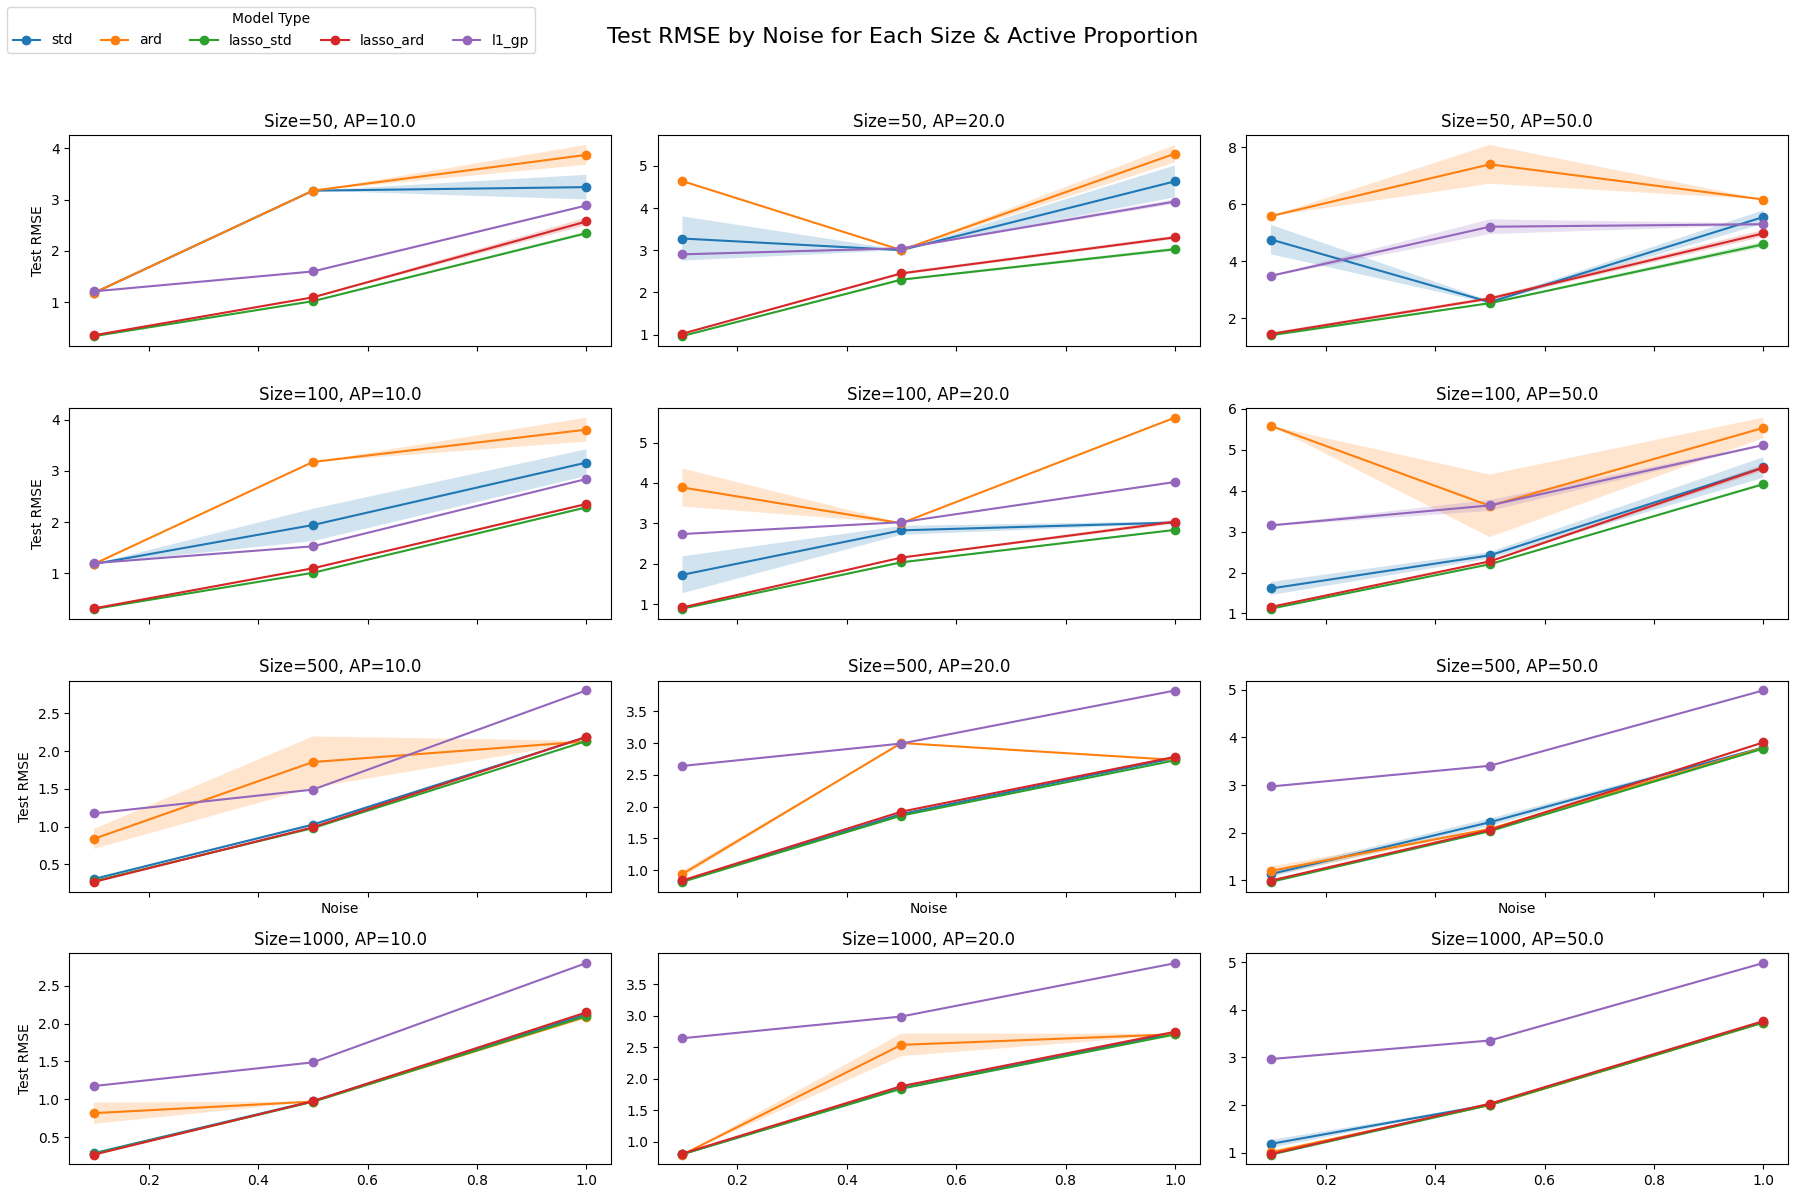

In [27]:
sizes = sorted(results['size'].unique())
aps = sorted(results['active proportion'].unique())

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 12), sharex=True, sharey=False)

for i, size in enumerate(sizes):
    for j, ap in enumerate(aps):
        ax = axes[i, j]
        subset = results[(results['size'] == size) & (results['active proportion'] == ap)]

        if subset.empty:
            ax.set_visible(False)
            continue

        rmse_by_noise = (
        subset.groupby(['noise', 'model type'])['testing rmse']
        .agg(['mean', 'std', 'count'])
        .reset_index()
        )
        rmse_by_noise['sem'] = rmse_by_noise['std'] / rmse_by_noise['count']**0.5
        rmse_by_noise['ci_lower'] = rmse_by_noise['mean'] - 1.96 * rmse_by_noise['sem']
        rmse_by_noise['ci_upper'] = rmse_by_noise['mean'] + 1.96 * rmse_by_noise['sem']

        hue_order = ['std', 'ard', 'lasso_std', 'lasso_ard', 'l1_gp']

        for model in hue_order:
            model_data = rmse_by_noise[rmse_by_noise['model type'] == model]
            model_data = model_data.copy()

            model_data[['noise', 'ci_lower', 'ci_upper']] = model_data[['noise', 'ci_lower', 'ci_upper']].apply(pd.to_numeric, errors='coerce')
            model_data.dropna(subset=['noise', 'mean', 'ci_lower', 'ci_upper'], inplace=True)  # drop rows with NaN in these columns

            if model_data.empty:
                continue

            ax.plot(model_data['noise'], model_data['mean'], marker='o', label=model)
            ax.fill_between(model_data['noise'], model_data['ci_lower'], model_data['ci_upper'], alpha=0.2)

        ax.set_title(f'Size={size}, AP={ap}')
        if i == 2:
            ax.set_xlabel('Noise')
        else:
            ax.set_xlabel('')
        if j == 0:
            ax.set_ylabel('Test RMSE')
        else:
            ax.set_ylabel('')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Model Type', loc='upper left', ncol=5)
plt.suptitle('Test RMSE by Noise for Each Size & Active Proportion', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Empty DataFrame
Columns: [model type, size, active proportion, noise, seed, selected features, precision, recall, training rmse, testing rmse, beta_error, tune time, fit time, prediction time (test), total runtime, lambda]
Index: []
[]
[]
Empty DataFrame
Columns: [size, model type, mean, std, count, sem, ci_lower, ci_upper]
Index: []

Model: std
size           object
model type     object
mean           object
std           float64
count           int64
sem           float64
ci_lower       object
ci_upper       object
dtype: object
Empty DataFrame
Columns: [size, ci_lower, ci_upper]
Index: []


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

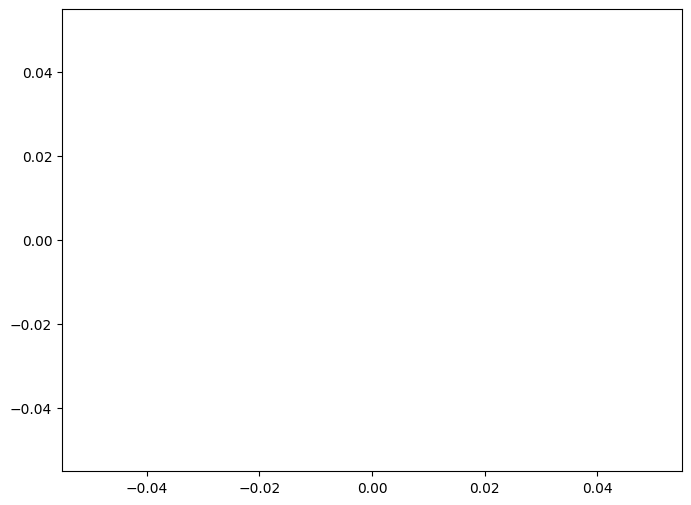

In [31]:
# size by rmse for noise = 0.5, active proportion = 0.1

subset = results[(results['noise'] == 0.5) & (results['active proportion'] == 0.1)]

rmse_by_size = (
    subset.groupby(['size', 'model type'])['testing rmse']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)
rmse_by_size['sem'] = rmse_by_size['std'] / rmse_by_size['count']**0.5
rmse_by_size['ci_lower'] = rmse_by_size['mean'] - 1.96 * rmse_by_size['sem']
rmse_by_size['ci_upper'] = rmse_by_size['mean'] + 1.96 * rmse_by_size['sem']

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
hue_order = ['std', 'ard', 'lasso_std', 'lasso_ard', 'l1_gp']

print(subset.head())
print(subset['size'].unique())
print(subset['model type'].unique())

print(rmse_by_size.head())

for model in hue_order:
    model_data = rmse_by_size[rmse_by_size['model type'] == model]

    model_data = model_data.copy()
    model_data[['size', 'ci_lower', 'ci_upper']] = model_data[['size', 'ci_lower', 'ci_upper']].apply(pd.to_numeric, errors='coerce')
    model_data.dropna(subset=['size', 'ci_lower', 'ci_upper'], inplace=True)
    print(f"\nModel: {model}")
    print(model_data.dtypes)
    print(model_data[['size', 'ci_lower', 'ci_upper']])
    ax.plot(model_data['size'], model_data['mean'], marker='o', label=model)
    ax.fill_between(model_data['size'], model_data['ci_lower'], model_data['ci_upper'], alpha=0.2)

ax.set_xlabel('Dataset Size')
ax.set_ylabel('Test RMSE')
ax.set_title('Test RMSE vs Dataset Size\n(Noise = 0.5, Active Proportion = 0.1)')
ax.grid(True)
ax.legend(title='Model Type')
plt.tight_layout()
plt.show()


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

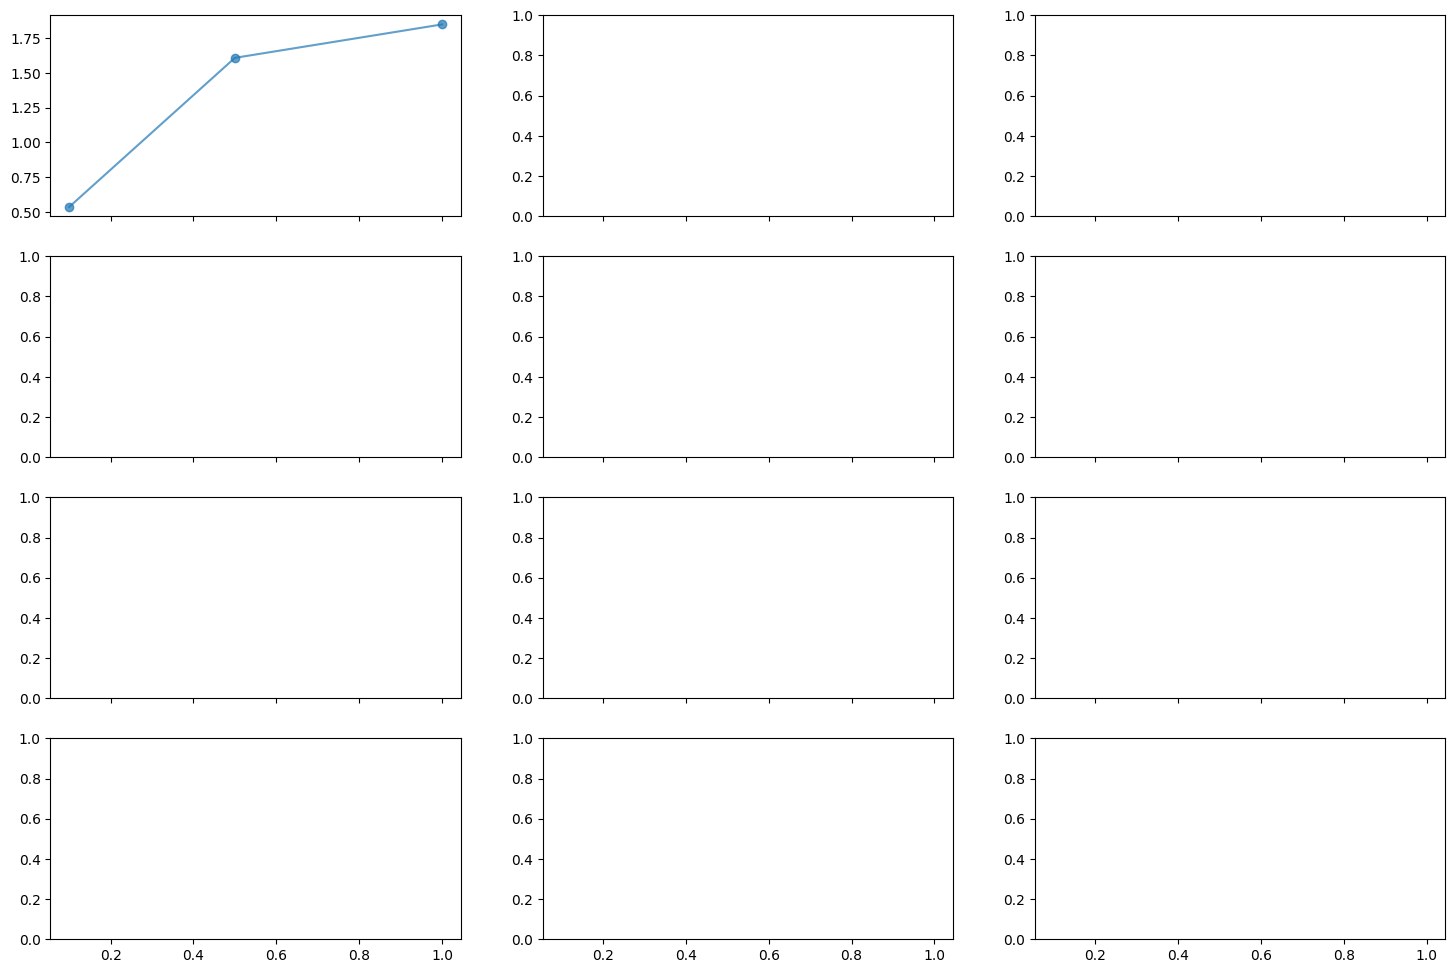

In [17]:

metric = 'training rmse'
#metric = 'prediction time (test)' # change this to inspect different metrics

sizes = sorted(results['size'].unique())
aps = sorted(results['active proportion'].unique())

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 12), sharex=True, sharey=False)

for i, size in enumerate(sizes):
    for j, ap in enumerate(aps):
        ax = axes[i, j]
        subset = results[(results['size'] == size) & (results['active proportion'] == ap)]

        if subset.empty:
            ax.set_visible(False)
            continue

        rmse_by_noise = (
        subset.groupby(['noise', 'model type'])[metric]
        .agg(['mean', 'std', 'count'])
        .reset_index()
        )
        rmse_by_noise['sem'] = rmse_by_noise['std'] / rmse_by_noise['count']**0.5
        rmse_by_noise['ci_lower'] = rmse_by_noise['mean'] - 1.96 * rmse_by_noise['sem']
        rmse_by_noise['ci_upper'] = rmse_by_noise['mean'] + 1.96 * rmse_by_noise['sem']

        hue_order = ['std', 'ard', 'lasso_std', 'lasso_ard', 'l1_gp']

        for model in hue_order:
            model_data = rmse_by_noise[rmse_by_noise['model type'] == model]
            ax.plot(model_data['noise'], model_data['mean'], marker='o', label=model, alpha = 0.7)
            ax.fill_between(model_data['noise'], model_data['ci_lower'], model_data['ci_upper'], alpha=0.2)

        ax.set_title(f'Size={size}, AP={ap}')
        if i == 2:
            ax.set_xlabel('Noise')
        else:
            ax.set_xlabel('')
        if j == 0:
            ax.set_ylabel(f'{metric}')
        else:
            ax.set_ylabel('')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Model Type', loc='upper left', ncol=5)
plt.suptitle(f'{metric} by Noise for Each Size & Active Proportion', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
